# Model Training - Non Parallel (Single GPU)

In this notebook we fine tune the pre-trained resnet50 model on the spectrogram image data on a single GPU, and collect metrics for comparison with parallel training approaches on multiple GPUs such as DDP and Model Parallel

In [1]:
import os
import shutil
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from torchvision.models import resnet50
import torch.multiprocessing as mp
import torch.distributed as dist
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import time
from torch.optim.lr_scheduler import StepLR

In [2]:
torch.cuda.device_count()

1

In [3]:
# Split the dataset into train, validation and test
def create_splits(data_dir, output_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    splits = {'train': train_size, 'val': val_size, 'test': test_size}

    assert sum(splits.values()) == 1, "Sum of split sizes should be 1."

    # Output directories for the splits
    for split in splits.keys():
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    # Iterate over each class directory
    for cls in classes:
        class_dir = os.path.join(data_dir, cls)
        images = [img for img in os.listdir(class_dir) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
        # Stratified splits
        train_val, test = train_test_split(images, test_size=splits['test'], random_state=42, stratify=None)
        train, val = train_test_split(train_val, test_size=splits['val'] / (splits['train'] + splits['val']), random_state=42, stratify=None)

        # Function to copy files to directories
        def copy_files(files, split):
            for f in files:
                src = os.path.join(class_dir, f)
                dst = os.path.join(output_dir, split, cls, f)
                shutil.copy(src, dst)

        # Copy files to respective split directories
        copy_files(train, 'train')
        copy_files(val, 'val')
        copy_files(test, 'test')


data_dir = 'dataset_spec/'
output_dir = 'dataset_splits/'
create_splits(data_dir, output_dir)

In [4]:
# Data Augmentation using dask
class CustomDataset(Dataset):
    def __init__(self, ddf, transform=None):
        self.ddf = ddf
        self.transform = transform

    def __len__(self):
        return len(self.ddf)

    def __getitem__(self, idx):
        row = self.ddf.iloc[idx]
        image_path = row['path']
        class_label = row['class']
        transformed_image = row['transformed_image']
        if isinstance(transformed_image, str):  # If transformed_image is a path
            image = Image.open(transformed_image)
        else:
            image = Image.fromarray(transformed_image)
        if self.transform:
            image = self.transform(image)
        return image, class_label

def add_augmented_images(root_dir, ddf):

    # check for data folder
    os.makedirs(root_dir, exist_ok=True)
    # iterate over dask dataframe containing transformed images
    for _, row in ddf.iterrows():
        class_name = row['class']
        image_path = row['path']
        class_dir = os.path.join(root_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        image_filename = os.path.basename(image_path)
        image_dest_path = os.path.join(class_dir, image_filename)
        if not os.path.exists(image_dest_path):
            # move images to the respective directory
            shutil.copy(image_path, image_dest_path)

def get_data_loader(batch_size, data_path, train=True):
    print("get data loader")
    if train:
        transform = transforms.Compose([
       transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
         transforms.RandomRotation(10),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
     ])

        image_paths = []
        for class_name in os.listdir(data_path):
            print(class_name)
            class_dir = os.path.join(data_path, class_name)
            for sample_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, sample_name)
                image_paths.append((class_name, image_path))
        # Using Dask Dataframes
        ddf = dd.from_pandas(pd.DataFrame(image_paths, columns=['class', 'path']), npartitions=4)
        # Create a custom dataset instance using your Dask DataFrame
        dataset = CustomDataset(ddf, transform=transform)
        add_augmented_images(data_path, ddf)
        # load data after augmentation
        dataset = datasets.ImageFolder(data_path, transform=transform)

    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image_paths = []
        for class_name in os.listdir(data_path):
            print(class_name)
            class_dir = os.path.join(data_path, class_name)
            for sample_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, sample_name)
                image_paths.append((class_name, image_path))
        # Using Dask Dataframes
        ddf = dd.from_pandas(pd.DataFrame(image_paths, columns=['class', 'path']), npartitions=4)
        # Create a custom dataset instance using your Dask DataFrame
        dataset = CustomDataset(ddf, transform=transform)
        add_augmented_images(data_path, ddf)
        dataset = datasets.ImageFolder(data_path, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=train, num_workers=4, pin_memory=True)
    return data_loader

In [5]:
# Resnet 50 - Fine-Tuning / Transfer Learning on Spectrogram Dataset

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data directories
data_dir = 'dataset_splits/'
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
test_dir = f'{data_dir}/test'

#data loaders
train_loader = get_data_loader(64, train_dir, train=True)
val_loader = get_data_loader(64, val_dir, train=False)


get data loader
GPD
GRDA
LPD
LRDA
Other
Seizure
get data loader
GPD
GRDA
LPD
LRDA
Other
Seizure


/home/kunigalharish.a/.conda/envs/akshay_py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kunigalharish.a/.conda/envs/akshay_py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 1.7311, Accuracy: 27.09%
Validation Loss: 1.5935, Accuracy: 34.10%
Epoch 2/10, Loss: 1.6712, Accuracy: 30.47%
Validation Loss: 1.5525, Accuracy: 37.04%
Validation Loss: 1.5202, Accuracy: 38.46%
Validation Loss: 1.5464, Accuracy: 37.59%
Epoch 5/10, Loss: 1.6242, Accuracy: 33.20%
Validation Loss: 1.5157, Accuracy: 39.68%
Epoch 6/10, Loss: 1.6145, Accuracy: 33.67%
Validation Loss: 1.4883, Accuracy: 40.20%
Epoch 7/10, Loss: 1.6041, Accuracy: 34.16%
Validation Loss: 1.4689, Accuracy: 41.81%
Validation Loss: 1.4499, Accuracy: 42.98%
Epoch 9/10, Loss: 1.5709, Accuracy: 35.77%
Validation Loss: 1.4378, Accuracy: 43.47%
Epoch 10/10, Loss: 1.5643, Accuracy: 36.18%
Validation Loss: 1.4513, Accuracy: 43.03%
Elapsed Time - Serial Training (1 GPU) : 15239.413598775864


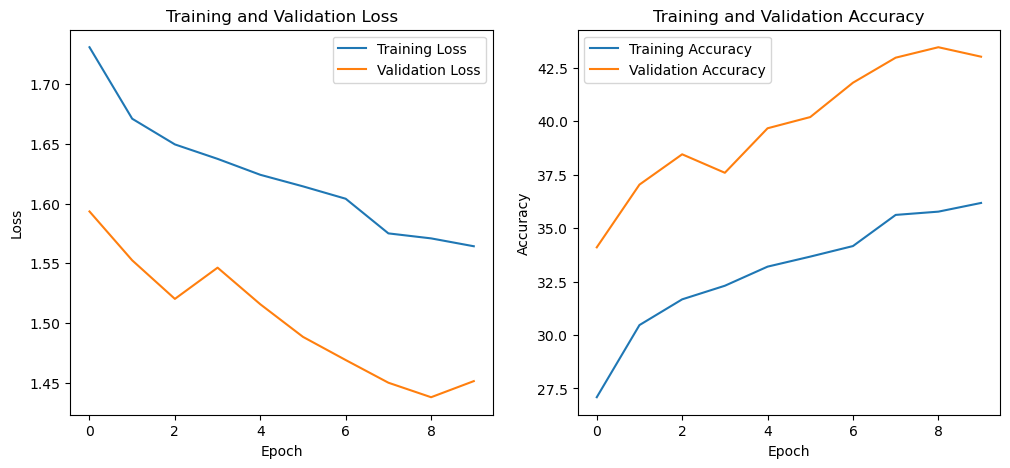

In [6]:

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data directories
data_dir = 'dataset_splits/'
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
test_dir = f'{data_dir}/test'

# Data Loaders
train_loader = get_data_loader(128, train_dir, train=True)
val_loader = get_data_loader(128, val_dir, train=False)


# Model setup
model = models.resnet50(pretrained=True) # Pre-trained ResNet50 

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# adjusting model architecture to fine-tune resnet-50 to classify spectrogram images
num_ftrs = model.fc.in_features 
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 6) 
)
model = model.to(device)

# Unfreeze some of the last layers of the network
for param in model.layer4.parameters():
    param.requires_grad = True

# Loss
criterion = nn.CrossEntropyLoss()

# Optimzer 
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},  
    {'params': model.fc.parameters()}  
], lr=0.001)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


# Training Function
def train_model(num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)# move image tensors to GPU

            optimizer.zero_grad()#optimizer
            outputs = model(images)
            loss = criterion(outputs, labels)# compute loss
            loss.backward()# backpropagate loss
            optimizer.step()

            # generate predictions to calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

        # compute validation loss, accuracy
        val_loss, val_accuracy = validate_model()
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return train_losses, train_accuracies, val_losses, val_accuracies

# Validation Function
def validate_model():
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * images.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
    return val_loss, val_accuracy


# Main
if __name__ == "__main__":
    start_time = time.time()
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(num_epochs=10)
    elapsed_time = time.time() - start_time
    print(f"Elapsed Time - Serial Training (1 GPU) : {elapsed_time}")

    # Plotting Train and Validation Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting Train and Validation Accuracy

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig('Acc_Loss.png')
    plt.show()

    # Save Training time of model
    with open("Training_time.csv", "a+") as pc:
      pc.write('Type, Elapsed_time')
      pc.write(f'Serial,{elapsed_time}\n')
